<a href="https://colab.research.google.com/github/CS23M005/DL_A1/blob/main/FFNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install wandb
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from keras.datasets import mnist
import random

In [4]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train/255
X_test = X_test/255

4422102/4422102 [==============================] - 0s 0us/step


In [5]:
samples_for_print = [];
unique_labels = np.unique(y_train)
u_l = np.copy(unique_labels)

while(len(unique_labels)>0):
  for i in range (0, len(y_train)):
    if(y_train[i] == unique_labels[0]):
      samples_for_print.append(X_train[i])
      unique_labels = np.setdiff1d(unique_labels,unique_labels[0])
      break


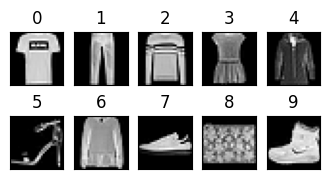

In [6]:
i = 1
rows = 2
cols = int(len(samples_for_print)/rows)
plt.figure(figsize = (4,2))
for img in samples_for_print:
    plt.subplot(rows, cols, i)
    plt.imshow(img, cmap='gray')
    plt.title(u_l[i-1])
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    i = i+1
plt.show()

In [7]:
from random import seed
import random

def init_random(n1, n2, init_mode, xav_std):
  if init_mode == "random":
    return [[np.random.normal(0,1) for i in range(n1)] for j in range(n2)]
  elif init_mode == "xavier":
    return [[np.random.normal(0,xav_std) for i in range(n1)] for j in range(n2)]

def init_nn(n_inputs, n_layers, n_neurons, n_outputs, init_mode):
  w = [0]*(n_layers+2)
  biases = []
  xavier_stddev = np.sqrt(2 / (n_inputs + n_outputs))
  input_layer = init_random(n_inputs, n_neurons, init_mode, xavier_stddev)
  w[1] = input_layer
  biases.append([0])
  biases.append(init_random(n_neurons, 1, init_mode, xavier_stddev)[0])
  for i in range(2,n_layers+1):
    hidden_layer = init_random(n_neurons, n_neurons, init_mode, xavier_stddev)
    w[i] = hidden_layer
    biases.append(init_random(n_neurons, 1, init_mode, xavier_stddev)[0])
  output_layer = init_random(n_neurons, n_outputs, init_mode, xavier_stddev)
  w[n_layers+1] = output_layer
  biases.append(init_random(n_outputs, 1, init_mode, xavier_stddev)[0])
  return w, biases



In [8]:
def sigmoid(x):
  return 1. / (1.+np.exp(-x))

def sigmoid_derivative(x):
  return sigmoid(x) * (1-sigmoid(x))

def Relu(x):
  return np.maximum(0,x)

def Relu_derivative(x):
  return 1*(x>0)

def tanh(x):
  return np.tanh(x)

def tanh_derivative(x):
  return (1 - (np.tanh(x)**2))

def softmax(x):
  return np.exp(x) / np.sum(np.exp(x), axis=0)

def softmax_derivative(x):
  return softmax(x) * (1-softmax(x))

def oneHotEncode(y_actual, n_outputs):
  Ydata = np.zeros(n_outputs)
  Ydata[int(y_actual)] = 1
  return Ydata



In [9]:

def forward_prop(w, b, sample, n_layers):
  a = []
  h = []
  h.append(sample)
  a.append([0])
  for i in range(1, n_layers+1):
    a.append(np.matmul(np.array(w[i]),np.array(h[i-1]))+b[i])
    h.append(sigmoid(a[i]))
  a.append(np.matmul(w[n_layers+1],h[n_layers])+b[n_layers+1])
  y = softmax(a[n_layers+1])
  return y, a, h



In [10]:

def backprop(y_hat, y_actual, a, h, w, b, activation_f, batch_size, loss, ud_lambda, n_outputs):

    L = len(w)-1
    gradient_a = [0]*(L+1)
    gradient_w = [0]*(L+1)
    gradient_b = [0]*(L+1)
    gradient_h = [0]*(L+1)
    y = oneHotEncode(y_actual, n_outputs)

    if loss == 'crossentropy':
      gradient_a[L] = y_hat-y
    elif loss == 'mse':
      gradient_a[L] = np.multiply(2 * (y_hat - y), np.multiply(y_hat, (1 - y_hat)))

    for k in range(L,0,-1):
      gradient_w[k] = (np.outer(gradient_a[k], h[k-1].transpose()))
      gradient_b[k] = gradient_a[k]

      if (k > 1):
        if activation_f == 'sigmoid':
          gradient_h[k-1] = np.matmul(np.array(w[k]).transpose(), np.array(gradient_a[k]))
          gradient_a[k-1]  =np.array(gradient_h[k-1]) * np.array(sigmoid_derivative(a[k-1]))

        elif activation_f == 'relu':
          gradient_h[k-1] = np.matmul(np.array(w[k]).transpose(), np.array(gradient_a[k]))
          gradient_a[k-1]  =np.array(gradient_h[k-1]) * np.array(Relu_derivative(a[k-1]))

        elif activation_f == 'tanh':
          gradient_h[k-1] = np.matmul(np.array(w[k]).transpose(), np.array(gradient_a[k]))
          gradient_a[k-1]  =np.array(gradient_h[k-1]) * np.array(tanh_derivative(a[k-1]))

    return gradient_w, gradient_b


In [11]:


def sgd(n_inputs, n_layers, n_neurons, n_outputs, activation_f, batch_size, loss, ud_lambda, eta, init_mode, w, b, use_wandb):
  for i in range(3):
    dw, db = 0,0
    num_points_seen = 0
    for x,y in zip(X_train, y_train):
      sample = x.flatten()
      y_hat, a, h = forward_prop(w, b, sample, n_layers)
      temp_dw, temp_db = backprop(y_hat, y, a, h, w, b, activation_f, batch_size, loss, ud_lambda, n_outputs)
      if(num_points_seen==0):
        dw, db = temp_dw, temp_db
      num_points_seen = num_points_seen + 1
      for j in range(1, n_layers+2):
          dw[j] = dw[j]+ np.array(temp_dw[j])
          db[j] = db[j]+ np.array(temp_db[j])
      if num_points_seen % batch_size == 0:
        for j in range(1, n_layers+2):
          w[j] = (w[j]-eta*dw[j]) - eta*ud_lambda*np.array(w[j])
          b[j] = b[j]-eta*db[j]
  return w,b,a,h



In [12]:
def accuracy(x_data,y_data, w, b):
  count = 0
  y_p = []
  for x,y in zip(x_data,y_data):
    sample = x.flatten()
    y_hat, a_dum, h_dum = forward_prop(w, b, sample, n_layers)
    y_pred = np.argmax(y_hat, axis=0)
    y_p.append(y_pred)
    if y_pred == y:
      count += 1
  accuracy = count/len(y_data)
  print(count)
  return accuracy, y_p



In [23]:
sweep_config = {"name": "sw2", "method": "random"}
sweep_config["metric"] = {"name": "test_accuracy", "goal": "maximize"}
parameters_dict = {
                "num_epochs": {"values": [5, 10]}, \
                "num_hidden_layers": {"values": [3, 4, 5]}, \
                "size_hidden_layer": {"values": [32, 64, 128]}, \
                "learning_rate": {"values": [1e-3, 1e-4]}, \
                # "optimizer": {"values": ["sgd"]}, #,"Momentum","AdaGrad","RMSProp","Adam","Nadam"]}, \
                "batch_size": {"values": [128, 1024, 5000]}, \
                "weight_init": {"values": ["random", "xavier"]} , \
                "activation": {"values": ["sigmoid", "tanh", "relu"]}, \
                "loss": {"values": ["crossentropy"]}, \
                "reg_lambda": {"values": [0.1, 0.01]}, \
                  }
sweep_config["parameters"] = parameters_dict

In [26]:
def train_nn(config = sweep_config):
  with wandb.init(config = config):
    config = wandb.config
    wandb.run.name = "e_{}_hl_{}_opt_{}_bs_{}_init_{}_ac_{}_loss_{}".format(config.num_epochs,\
                                                                  config.num_hidden_layers,\
                                                                  config.size_hidden_layer,\
                                                                  config.learning_rate,\
                                                                  #config.optimizer,\
                                                                  config.batch_size,\
                                                                  config.weight_init,\
                                                                  config.activation,\
                                                                  config.loss,\
                                                                  config.reg_lambda)

    seed(29)
    n_inputs = 784
    n_layers = config.size_hidden_layer
    n_neurons = config.size_hidden_layer
    n_outputs = 10
    init_mode = config.weight_init
    w,b = init_nn(n_inputs, n_layers, n_neurons, n_outputs, init_mode)
    w_old = w.copy()
    b_old = b.copy()

    eta = config.learning_rate
    activation_f = config.activation
    batch_size = config.batch_size
    loss = config.loss
    ud_lambda = config.reg_lambda
    print("before sgd  call")
    w_n,b_n, a_n, h_n = sgd(n_inputs, n_layers, n_neurons, n_outputs, activation_f, batch_size, loss, ud_lambda, eta, init_mode, w, b, use_wandb=True)
    print("after sgd call")
    train_accuracy, yp = accuracy(X_train, y_train, w_n, b_n)
    test_accuracy, ytp = accuracy(X_test, y_test, w_n, b_n)


    wandb.log({"train_acc": train_accuracy, \
                "test_acc": test_accuracy, \
                })
    print("accu: ", test_accuracy)


####################################################################
sweep_id = wandb.sweep(sweep_config, project = "Assignment1")
wandb.agent(sweep_id, function = train_nn, count=1)
wandb.finish()


Create sweep with ID: 2ath1duu
Sweep URL: https://wandb.ai/cs23m005/Assignment1/sweeps/2ath1duu


wandb: Ctrl + C detected. Stopping sweep.


In [240]:
# print(train_accuracy*100)
# print(test_accuracy*100)

61.66166666666667
61.17


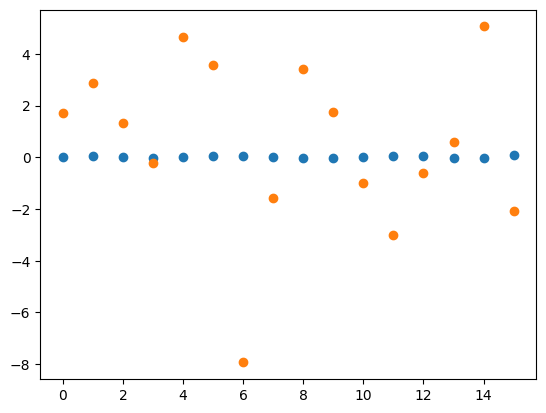

In [241]:
# plt.plot(w_old[n_layers][1], 'o')
# plt.plot(w_n[n_layers][1], 'o')
# # plt.show()

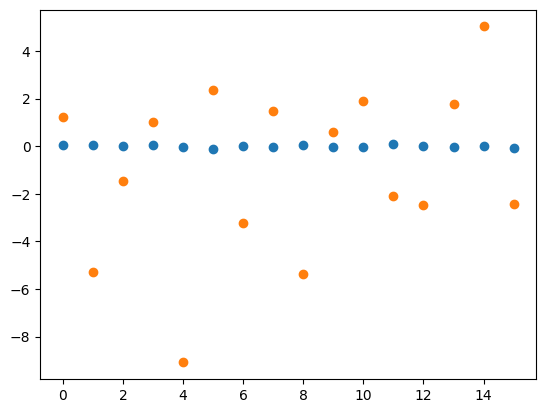

In [242]:
# plt.plot(b_old[1], 'o')
# plt.plot(b_n[1], 'o')
# plt.show()

In [ ]:
# sample = X_train[0].flatten()
# y_hat, a, h = forward_prop(w, b, sample, n_layers)
# dw, db = backprop(y_hat, y_train[0], a, h, w, b, activation_f, batch_size, loss, ud_lambda, n_outputs)

In [ ]:
# for i in range(0,n_layers+2):
#   print(np.array(b[i]).shape)